<a href="https://colab.research.google.com/github/jose-cano/Gemini-Streamlit/blob/master/2_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install tqdm_joblib

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import  train_test_split
from tqdm.autonotebook import tqdm
from tqdm_joblib import tqdm_joblib

<ipython-input-2-b1f01dff29a5>:4: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [ ]:
# Inspect data is as expected
df = pd.read_csv("clean_data.csv").drop(columns="AnimalID")
df.head()

,OutcomeType,AnimalType,Breed,Color,has_name,day_of_week,is_weekend,month,year,days_upon_outcome,fertile,sex
0,Return_to_owner,1,Shetland Sheepdog Mix,Brown/White,1,2,0,2,2014,365.0,0.0,1.0
1,Euthanasia,0,Domestic Shorthair Mix,Cream Tabby,1,6,1,10,2013,365.0,0.0,0.0
2,Adoption,1,Pit Bull Mix,Blue/White,1,5,1,1,2015,730.0,0.0,1.0
3,Transfer,0,Domestic Shorthair Mix,Blue Cream,0,4,0,7,2014,21.0,1.0,1.0
4,Transfer,1,Lhasa Apso/Miniature Poodle,Tan,0,4,0,11,2013,730.0,0.0,1.0


In [ ]:
df.dtypes

,0
OutcomeType,object
AnimalType,int64
Breed,object
Color,object
has_name,int64
day_of_week,int64
is_weekend,int64
month,int64
year,int64
days_upon_outcome,float64


In [ ]:
X = df.drop(columns=['OutcomeType'])
y = df['OutcomeType']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42, stratify=y)

In [ ]:
y_train.value_counts()

,count
OutcomeType,
Adoption,7538
Transfer,6595
Return_to_owner,3350
Euthanasia,1089
Died,138


In [ ]:
y_test.value_counts()

,count
OutcomeType,
Adoption,3231
Transfer,2827
Return_to_owner,1436
Euthanasia,466
Died,59


In [ ]:
from sklearn.preprocessing import LabelEncoder # xgboost expects labels to be numerically encoded

le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)

le.classes_

array(['Adoption', 'Died', 'Euthanasia', 'Return_to_owner', 'Transfer'],
      dtype=object)

In [ ]:
# Based on our understanding of the data/how we encoded these features
numerical_features = ['days_upon_outcome']
categorical_features = ["AnimalType",'has_name', 'day_of_week', 'is_weekend', 'month', 'year', 'fertile', 'sex']
ohe_features = ["Breed", "Color"]
numerical_features, categorical_features, ohe_features

(['days_upon_outcome'],
 ['AnimalType',
  'has_name',
  'day_of_week',
  'is_weekend',
  'month',
  'year',
  'fertile',
  'sex'],
 ['Breed', 'Color'])

In [ ]:
# Define preprocessing steps using Pipeline
# Define on which columns to apply those steps using ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# Specify what preprocessing steps you need
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer

In [ ]:
# The Pipeline object is used to specify preprocessing steps to apply in order
# E.g. for the numerical features, we will first impute and then scale
# Also note the first item in the tuple is a string. We call these named steps, which we can refrence.
# This is useful when we want to specify different parameters in grid search.

numerical_preprocessor = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median", add_indicator=True)),
    ("scaler", StandardScaler())
])

categorical_preprocessor = Pipeline(steps=[
    ("imputer",SimpleImputer(strategy="most_frequent", add_indicator=True, fill_value="Unknown")), # fill value only used when strategy = 'constant', but needs to be initialized
])

ohe_1 = Pipeline(steps=[
    ("imputer",SimpleImputer(strategy="most_frequent", add_indicator=True, fill_value="Unknown")),
    ("encoder", OneHotEncoder(handle_unknown="ignore", min_frequency=None)) # optimal val can be searched
])

ohe_2 = Pipeline(steps=[
    ("imputer",SimpleImputer(strategy="most_frequent", add_indicator=True, fill_value="Unknown")),
    ("encoder", OneHotEncoder(handle_unknown="ignore", min_frequency=None))
])

ohe_3 = Pipeline(steps=[
    ("imputer",SimpleImputer(strategy="most_frequent", add_indicator=True, fill_value="Unknown")),
    ("encoder", OneHotEncoder(handle_unknown="ignore", min_frequency=None))
])

**Note on time features**:
These are typically considered categorical (or cyclic) features. They represent discrete groups (e.g., Monday–Sunday or January–December) without a linear ordering that has a meaningful numeric distance.

No need to standardize: Since they aren’t continuous measurements, standardization isn’t appropriate.
Encoding tips:
You might use one‐hot encoding if you want to avoid any unintended ordinal assumptions.
Alternatively, because they’re cyclic (e.g., December is close to January), you might apply sine/cosine transformations to capture that periodicity.

In [ ]:
# Specify on what columns to apply the steps using ColumnTransformer
# Also name these steps

preprocessor = ColumnTransformer(
    transformers=[
        ("numerical", numerical_preprocessor, numerical_features),
        ("categorical", categorical_preprocessor, categorical_features),
        ("ohe_1", ohe_1, [ohe_features[0]]),
        ("ohe_2", ohe_2, [ohe_features[1]]),
    ]
)

In [ ]:
# Try different models (no free lunch theorem)
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import GradientBoostingClassifier

In [ ]:
X_train

,AnimalType,Breed,Color,has_name,day_of_week,is_weekend,month,year,days_upon_outcome,fertile,sex
23796,0,Domestic Shorthair Mix,Black,0,2,0,10,2013,14.0,1.0,1.0
4092,1,Toy Poodle Mix,White,0,1,0,10,2013,1095.0,0.0,1.0
6712,1,Chihuahua Shorthair Mix,Tricolor,1,6,1,1,2016,210.0,0.0,1.0
15889,0,Domestic Shorthair Mix,Black,0,6,1,10,2013,365.0,1.0,1.0
16450,1,Pit Bull Mix,Black/White,1,3,0,11,2015,730.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
22666,1,Labrador Retriever/Jack Russell Terrier,Tan,1,1,0,3,2014,1460.0,0.0,1.0
15695,0,Domestic Shorthair Mix,Orange Tabby,0,2,0,7,2014,730.0,0.0,0.0
17365,0,Domestic Shorthair Mix,Blue/White,1,3,0,12,2014,1460.0,0.0,0.0
22837,0,Domestic Shorthair Mix,Brown Tabby/White,1,3,0,8,2015,180.0,0.0,1.0


In [ ]:
models = {
    'Logistic Regression': LogisticRegression(max_iter=100000, solver='sag'), # sag solver for large datasets
    'Random Forest': RandomForestClassifier(),
    'KNN': KNeighborsClassifier(),
    'Gradient Boosting': GradientBoostingClassifier(),
    'XGBoost': XGBClassifier(objective="multi:softmax", eval_metric="logloss")
}

X_cv_train = preprocessor.fit_transform(X_train)

# Evaluate each model using 5-fold cross validation
# https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter

for name, model in models.items():
    scores = cross_val_score(model, X_cv_train, y_train, cv=5, scoring='neg_log_loss') #https://scikit-learn.org/stable/modules/model_evaluation.html#string-name-scorers
    print(f"{name}: Mean CV Score = {np.mean(scores):.4f}")

In [ ]:
# XGB scored best

In [ ]:
# Combine the Pipeline and a Classifier
classifier = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier",  XGBClassifier(objective="multi:softmax"))
])

classifier

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numerical',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(add_indicator=True,
                                                                                 strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['days_upon_outcome']),
                                                 ('categorical',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(add_indicator=True,
                                                                                 fill_value='Unknown',
                                                                                 strategy='most_frequent'))]),
                                                  ['AnimalType', '...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=None,
                               num_parallel_tree=None,
                               objective='multi:softmax', ...))])

In [ ]:
from scipy.stats import randint, uniform

# Define parameter distributions
param_distributions = {
    'preprocessor__numerical__imputer__strategy': ['mean', 'median', 'most_frequent'],
    'preprocessor__numerical__imputer__add_indicator': [True, False],

    'preprocessor__categorical__imputer__add_indicator': [True, False],
    'preprocessor__ohe_1__encoder__min_frequency': [None, *range(1,70)],
    'preprocessor__ohe_2__encoder__min_frequency': [None, *range(1,70)],

    'classifier__n_estimators': randint(100, 1000),        # Number of boosting rounds
    'classifier__learning_rate': uniform(0.01, 0.3),       # Learning rate
    'classifier__max_depth': randint(2, 50),               # Maximum tree depth
    'classifier__min_child_weight': randint(1, 20),        # Minimum sum of instance weight (hessian) needed in a child
    'classifier__subsample': uniform(0.1, 0.9),            # Subsample ratio of the training instances
    'classifier__colsample_bytree': uniform(0.1, 0.9),     # Subsample ratio of columns when constructing each tree
    'classifier__gamma': uniform(0, 0.9)                   # Minimum loss reduction required to make a further partition
}

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

# Set up RandomizedSearchCV with 20 iterations and 5-fold cross-validation

n_iter = 120
cv = 3

random_search = RandomizedSearchCV(
    estimator=classifier,
    param_distributions=param_distributions,
    n_iter=n_iter,  # Number of parameter settings to sample
    cv=cv,       # 3-fold cross-validation
    n_jobs=-1,  # Use all processors
    scoring='neg_log_loss',  # Metric to optimize
    random_state=42,  # For reproducibility
    verbose=3
)

# Use tqdm_joblib to monitor progress: total iterations = n_iter * cv
with tqdm_joblib(tqdm(desc="RandomizedSearchCV", total=n_iter * cv)):
    random_search.fit(X_train, y_train)

RandomizedSearchCV:   0%|          | 0/360 [00:00<?, ?it/s]

  0%|          | 0/360 [00:00<?, ?it/s]

Fitting 3 folds for each of 120 candidates, totalling 360 fits


In [ ]:
# Print best parameters and cross-validation score
print("Best parameters found:")
print(random_search.best_params_)

# Evaluate on the test set using the best estimator found
best_model = random_search.best_estimator_
y_pred = best_model.predict(X_test)
y_pred_prob = best_model.predict_proba(X_test)

Best parameters found:
{'classifier__colsample_bytree': 0.5158052232797194, 'classifier__gamma': 0.8525550056506338, 'classifier__learning_rate': 0.05600542093482406, 'classifier__max_depth': 14, 'classifier__min_child_weight': 8, 'classifier__n_estimators': 309, 'classifier__subsample': 0.6503088118911831, 'preprocessor__categorical__imputer__add_indicator': True, 'preprocessor__numerical__imputer__add_indicator': False, 'preprocessor__numerical__imputer__strategy': 'most_frequent', 'preprocessor__ohe_1__encoder__min_frequency': 67, 'preprocessor__ohe_2__encoder__min_frequency': 4}


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, log_loss
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
log_loss(y_train, best_model.predict_proba(X_train))

0.7322852589285255

In [ ]:
log_loss(y_test, y_pred_prob)

0.8225466915602461

In [ ]:
print("\nClassification Report:")
print(classification_report(y_test, y_pred, zero_division=np.nan))


Classification Report:
              precision    recall  f1-score   support

           0       0.67      0.83      0.74      3231
           1        nan      0.00      0.00        59
           2       0.54      0.14      0.23       466
           3       0.47      0.45      0.46      1436
           4       0.74      0.66      0.70      2827

    accuracy                           0.66      8019
   macro avg       0.61      0.42      0.43      8019
weighted avg       0.65      0.66      0.64      8019



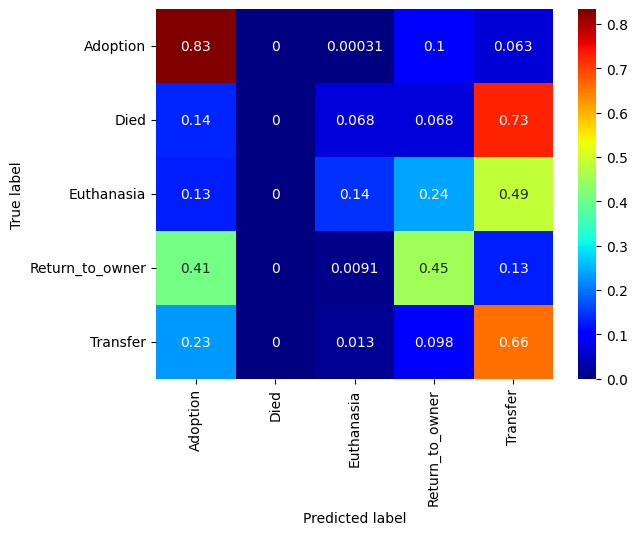

In [ ]:
cm = confusion_matrix(y_test, best_model.predict(X_test), normalize="true")
sns.heatmap(cm, annot=True, cmap='jet', xticklabels=le.classes_, yticklabels=le.classes_, )
plt.xlabel('Predicted label')
plt.ylabel('True label');

In [ ]:
best_model

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numerical',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['days_upon_outcome']),
                                                 ('categorical',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(add_indicator=True,
                                                                                 fill_value='Unknown',
                                                                                 strategy='most_frequent'))]),
                                                  ['AnimalType', 'has_name',
                                                   'd...
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None,
                               learning_rate=0.05600542093482406, max_bin=None,
                               max_cat_threshold=None, max_cat_to_onehot=None,
                               max_delta_step=None, max_depth=14,
                               max_leaves=None, min_child_weight=8, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=309, n_jobs=None,
                               num_parallel_tree=None,
                               objective='multi:softmax', ...))])

In [ ]:
# Save model
import joblib

joblib.dump(le, 'label_encoder.pkl')
joblib.dump(best_model, 'model.pkl')

['model.pkl']